In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import torch
from astropy.io import fits
from astropy.utils.data import download_file
#from torch.utils.tensorboard import SummaryWriter

from mpol import (
    coordinates,
    crossval,
    datasets,
    gridding,
    images,
    fourier,
    losses,
    precomposed,
)
from mpol.__init__ import zenodo_record

In [5]:
# load the mock dataset of the ALMA logo
fname = download_file(
    f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

# this is a multi-channel dataset... for demonstration purposes we'll use
# only the central, single channel
chan = 4
d = np.load(fname)
uu = d["uu"][chan]
vv = d["vv"][chan]
weight = d["weight"][chan]
data = d["data"][chan]
data_re = np.real(data)
data_im = np.imag(data)

# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(cell_size=0.03, npix=180)
averager = gridding.DataAverager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = averager.to_pytorch_dataset()

dset

GriddedDataset()

In [6]:
fname

'/Users/ramlal/.mpol/cache/download/url/58292501b4b512df5580c7c0dd5d9da7/contents'

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

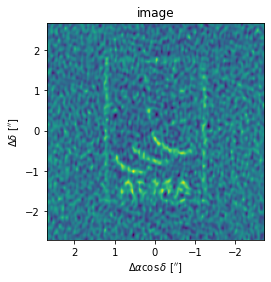

In [7]:
imager = gridding.DirtyImager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# Show the dirty image
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

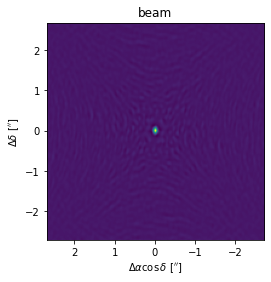

In [8]:
# Show the dirty beam
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(beam), **kw)
ax.set_title("beam")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

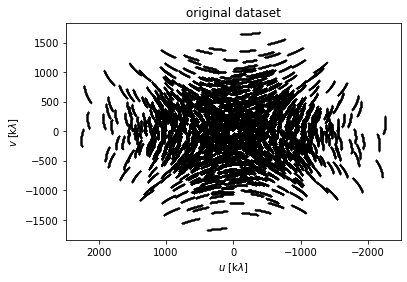

In [9]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(
    -uu, -vv, s=1.5, rasterized=True, linewidths=0.0, c="k"
)  # and Hermitian conjugates
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title("original dataset")
ax.invert_xaxis()

In [33]:
# create a radial and azimuthal partition
dartboard = datasets.Dartboard(coords=coords)

# create cross validator using this "dartboard"
k = 5
cv = crossval.DartboardSplitGridded(dset, k, dartboard=dartboard, seed=42)

# ``cv`` is a Python iterator, it will return a ``(train, test)`` pair of ``GriddedDataset``s for each iteration.
# Because we'll want to revisit the individual datasets
# several times in this tutorial, we're storeing them into a list
k_fold_datasets = [(train, test) for (train, test) in cv]

# k_fold_datasets[0][0].vis_gridded.shape

k_fold_datasets[0][0].ground_mask[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

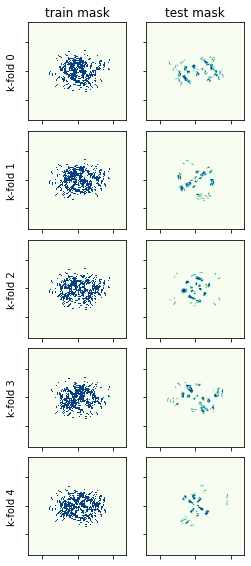

In [29]:
fig, ax = plt.subplots(nrows=k, ncols=2, figsize=(4, 10))

for i, (train_subset, test_subset) in enumerate(k_fold_datasets):

    # train_subset and test_subset are `GriddedDataset`s

    train_mask = train_subset.ground_mask[0]
    test_mask = test_subset.ground_mask[0]

    ax[i, 0].imshow(
        train_mask.detach().numpy(),
        interpolation="none",
        origin="lower",
        extent=coords.vis_ext,
        cmap="GnBu",
    )

    ax[i, 1].imshow(
        test_mask.detach().numpy(), origin="lower", extent=coords.vis_ext, cmap="GnBu"
    )

    ax[i, 0].set_ylabel("k-fold {:}".format(i))

ax[0, 0].set_title("train mask")
ax[0, 1].set_title("test mask")

for a in ax.flatten():
    a.xaxis.set_ticklabels([])
    a.yaxis.set_ticklabels([])

fig.subplots_adjust(left=0.15, hspace=0.0, wspace=0.2)

In [41]:
def train(model, dset, config, optimizer, writer=None):
    model.train()  # set to training mode

    for i in range(config["epochs"]):
        model.zero_grad()

        # get the predicted model
        vis = model()

        # get the sky cube too
        sky_cube = model.icube.sky_cube

        # calculate a loss
        loss = (
            losses.nll_gridded(vis, dset)
            + config["lambda_sparsity"] * losses.sparsity(sky_cube)
            + config["lambda_TV"] * losses.TV_image(sky_cube)
        )

        if writer is not None:
            writer.add_scalar("loss", loss.item(), i)

        # calculate gradients of parameters
        loss.backward()

        # update the model parameters
        optimizer.step()

In [37]:
def test(model, dset):
    model.train(False)
    # evaluate test score
    vis = model()
    loss = losses.nll_gridded(vis, dset)
    return loss.item()

In [38]:
def cross_validate(config):
    """
    config is a dictionary that should contain ``lr``, ``lambda_sparsity``, ``lambda_TV``, ``epochs``
    """
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):

        # create a new model and optimizer for this k_fold
        rml = precomposed.SimpleNet(coords=coords, nchan=train_dset.nchan)
        optimizer = torch.optim.Adam(rml.parameters(), lr=config["lr"])

        # train for a while
        train(rml, train_dset, config, optimizer)
        # evaluate the test metric
        test_scores.append(test(rml, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    return test_score

In [39]:
def train_and_image(pars):
    rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
    optimizer = torch.optim.Adam(rml.parameters(), lr=pars["lr"])
    writer = SummaryWriter()
    train(rml, dset, pars, optimizer, writer=writer)
    writer.close()

    img_ext = rml.coords.img_ext
    fig, ax = plt.subplots()
    ax.imshow(
        np.squeeze(rml.icube.sky_cube.detach().numpy()), origin="lower", extent=img_ext
    )
    return fig, ax

Cross validation score: 30.529687901854615


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

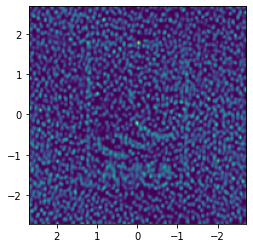

In [42]:
pars = {"lr": 0.5, "lambda_sparsity": 0, "lambda_TV": 0, "epochs": 600}
print("Cross validation score:", cross_validate(pars))
train_and_image(pars)

Cross validation score: 7.307591121512009


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

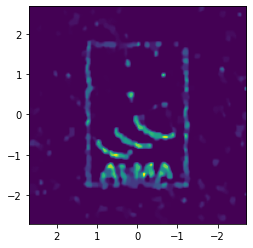

In [43]:
pars = {"lr": 0.5, "lambda_sparsity": 1e-4, "lambda_TV": 1e-4, "epochs": 600}
print("Cross validation score:", cross_validate(pars))
train_and_image(pars)